In [1]:
import os
import numpy as np
import pandas as pd
import mne
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pickle

import seaborn as sns



In [20]:
import os
import numpy as np
import pandas as pd
import mne
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pickle

def compute_and_save_itc_stats(pids, n_jobs=20):
    
    data_dir = '/mnt/data/AdaptiveControl/IBLrawdata/pid_data/'
    output_path = 'itcVScontrast_stats_results.pkl'
    
    # Define the contrast levels and corresponding conditions
    contrast_conditions = {
        '100%': (1, 1),
        '25%': (0.25, 0.25),
        '12.5%': (0.125, 0.125),
        '6%': (0.0625, 0.0625),
        '0%': (0, 0)
    }

    # Define time and frequency ranges of interest
    time_range = (-0.1, 0.5)
    freq_range = np.arange(1, 13, 1)  # Frequencies from 1 to 12 Hz

    # Function to compute mean ITC over the specified time and frequency range for a given subject and condition
    def compute_mean_itc(epochs, freqs, time_range, freq_range):
        print("  Computing ITC using Morlet wavelet...")
        n_cycles = freqs / 2  # Define the number of cycles for each frequency
        itc = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=True, average=True, n_jobs=n_jobs)[1]
        itc_avg = itc.data.mean(axis=0)  # Average over channels
        time_mask = (itc.times >= time_range[0]) & (itc.times <= time_range[1])
        freq_mask = (itc.freqs >= freq_range[0]) & (itc.freqs <= freq_range[-1])
        return itc_avg[freq_mask][:, time_mask].mean()

    # Create a DataFrame to store ITC values, subjects, and conditions
    data = []

    print(f"Starting ITC computation for {len(pids)} subjects...")
    for pid in pids:
        print(f"Processing subject {pid}...")
        # Load the epochs for each subject
        path = os.path.join(data_dir, pid, f'lfp_{pid}_epoched.fif')
        epochs = mne.read_epochs(path)
        epochs = epochs.crop(tmin=-1, tmax=1.5)
        # ch = epochs.ch_names
        # epochs = epochs.pick_channels(ch[0:1])
        meta = epochs.metadata

        # Identify clean trials based on skewness
        clean_index = meta.index[meta['skewness'] < 1.5].tolist()
        print(f"  Found {len(clean_index)} clean trials for subject {pid}...")

        subject_data = []

        for condition, (contrast_left, contrast_right) in contrast_conditions.items():
            print(f"  Processing condition {condition}...")
            # Select trials based on contrast level for the condition
            condition_trial_indices = np.where(((meta['contrastLeft'] == contrast_left) | 
                                                (meta['contrastRight'] == contrast_right)))[0]

            # Intersect with clean trials
            clean_condition_trials = np.intersect1d(condition_trial_indices, clean_index)

            # Select the epochs for this condition and compute mean ITC
            epochs_cond = epochs[clean_condition_trials]
            itc_mean = compute_mean_itc(epochs_cond, freqs=freq_range, time_range=time_range, freq_range=freq_range)
            
            # Check if the computed ITC contains NaN values
            if not np.isnan(itc_mean):
                subject_data.append({'subject': pid, 'condition': condition, 'contrast': float(condition.rstrip('%')), 'itc_mean': itc_mean})
            else:
                print(f"  NaN value encountered for subject {pid}, condition {condition}. Skipping this condition.")

        # If the subject has valid ITC data for all conditions, add it to the main data list
        if len(subject_data) == len(contrast_conditions):
            data.extend(subject_data)
            print(f"  Added ITC data for subject {pid}.")
        else:
            print(f"  Skipping subject {pid} due to missing data in one or more conditions.")

    # Convert the data list to a DataFrame for analysis
    df = pd.DataFrame(data)
        
    with open(output_path, 'wb') as f:
        pickle.dump({'data': df}, f)
    print(f"Model and data saved to {output_path}. Processing complete.")




In [21]:
import submitit

path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)
pids = df['pid'].values
# pids = pids[1:2]
executor = submitit.AutoExecutor(folder="logs")
# pass parameter to the executor
executor.update_parameters(mem_gb=40, timeout_min=600, slurm_partition="CPU", cpus_per_task=20)

# execute the job (note the .map_array command that different from the .submit command used above)
jobs = executor.submit(compute_and_save_itc_stats,pids)

In [9]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

result_path = 'itcVScontrast_stats_results.pkl'
# Load the model and data
with open(result_path, 'rb') as f:
    results = pickle.load(f)

model = results['model']
df = results['data']

# save df 
df.to_csv('itcVScontrast_stats_results.csv', index=False)

# normality test + rm anova

In [28]:
from scipy.stats import shapiro
from statsmodels.stats.anova import AnovaRM
import numpy as np

data = pd.read_csv('itcVScontrast_stats_results.csv')

# First, we'll pivot the data to get the ITC values for each contrast level per subject
data_pivot = data.pivot(index='subject', columns='contrast', values='itc_mean')

# Normality assumption: We'll use Shapiro-Wilk test for each contrast condition
normality_results = data_pivot.apply(shapiro)

# Conduct repeated measures ANOVA (without sphericity correction for initial check)
anova_model = AnovaRM(data, 'itc_mean', 'subject', within=['contrast'])
anova_results = anova_model.fit()

# Outputting the results
normality_results, anova_results.summary()


(contrast     0.0       6.0       12.5      25.0      100.0
 0         0.948272  0.927924  0.941984  0.974784  0.969119
 1         0.066137  0.013788  0.040354  0.502751  0.337387,
 <class 'statsmodels.iolib.summary2.Summary'>
 """
                  Anova
          F Value Num DF  Den DF  Pr > F
 ---------------------------------------
 contrast 33.3708 4.0000 156.0000 0.0000
 
 """)

### Normality (Shapiro-Wilk Test):

p-values for each contrast condition:
0% Contrast: 0.066 (not significant)
6% Contrast: 0.014 (significant)
12.5% Contrast: 0.040 (significant)
25% Contrast: 0.503 (not significant)
100% Contrast: 0.337 (not significant)

### ANOVA:
he ANOVA results show a significant effect of contrast on ITC, with 𝐹(4,156)=33.37, 𝑝< 0.0001


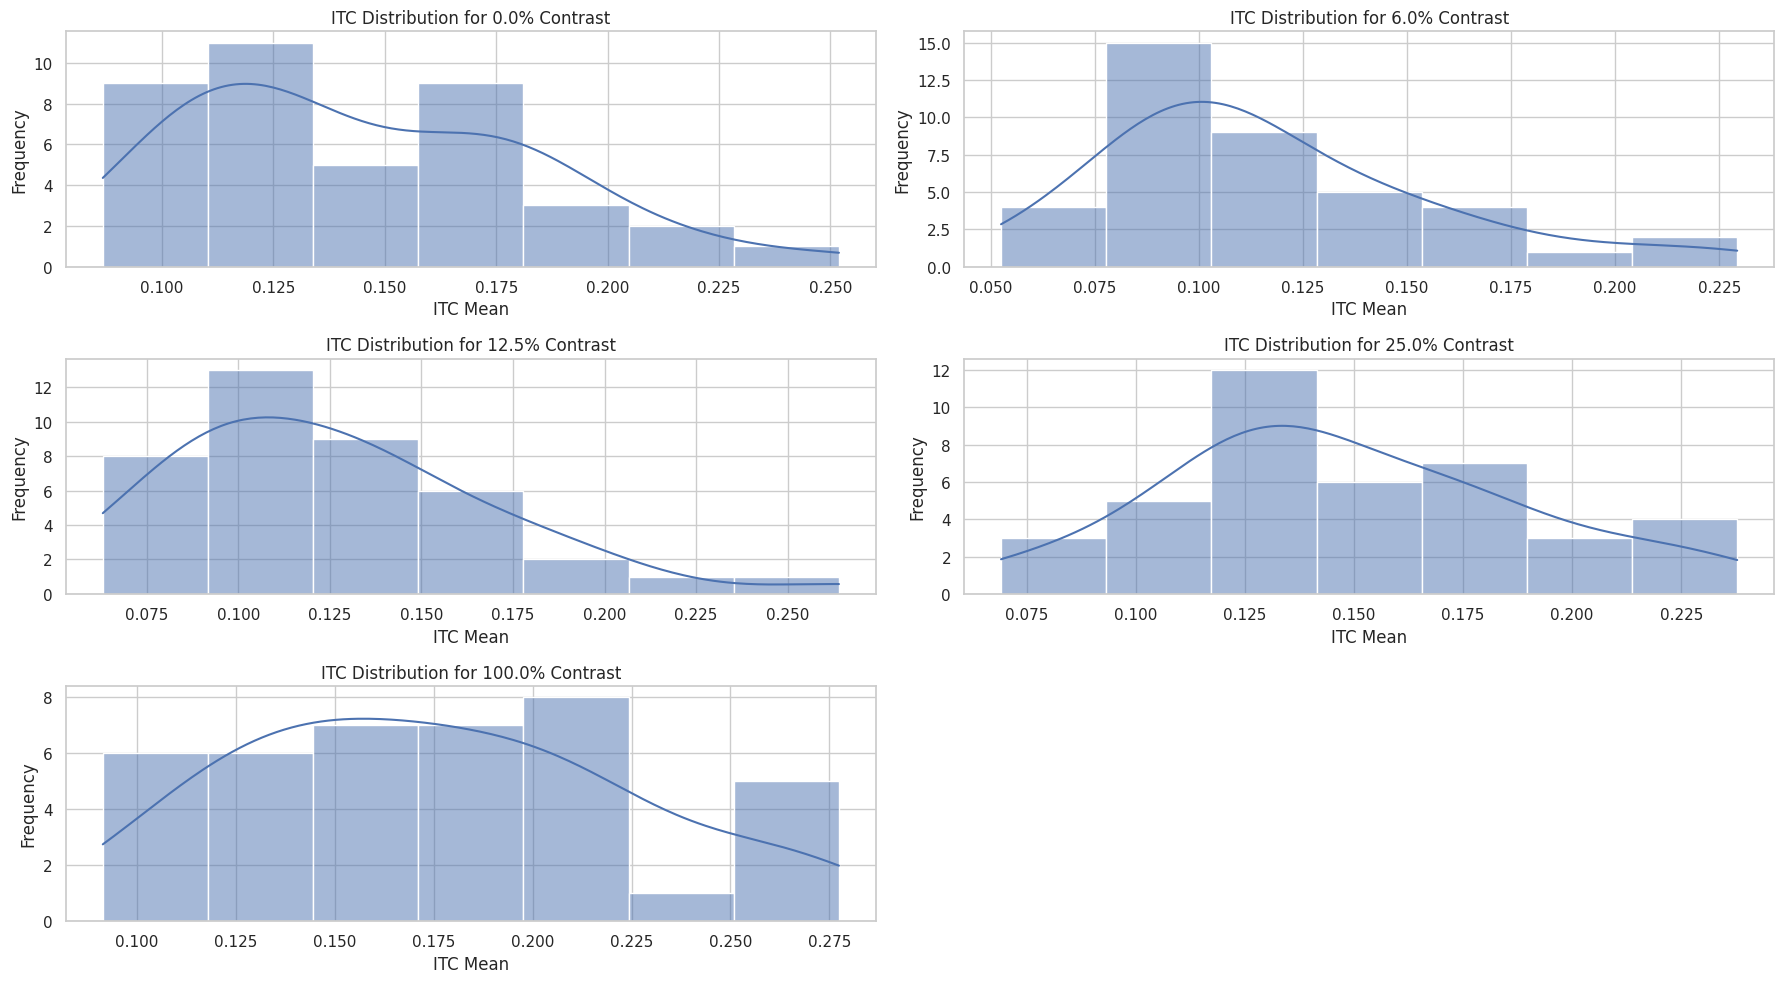

In [30]:
# Set up the plotting environment
plt.figure(figsize=(18, 10))
# Plot each contrast condition
for i, contrast in enumerate(sorted(data['contrast'].unique()), 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[data['contrast'] == contrast]['itc_mean'], kde=True)
    plt.title(f'ITC Distribution for {contrast}% Contrast')
    plt.xlabel('ITC Mean')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# friedmanchisquare 
because of the non-normality of the data, I used the Friedman .

In [1]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM



# Importing the necessary statistical test
from scipy.stats import friedmanchisquare


data = pd.read_csv('itcVScontrast_stats_results.csv')
# Pivot the data to have subjects as rows and contrast levels as columns
pivoted_data = data.pivot(index='subject', columns='contrast', values='itc_mean')

# Perform the Friedman test
statistic, p_value = friedmanchisquare(*pivoted_data.T.values)

# Display the result
statistic, p_value
(77.98000000000002, 4.664547873616418e-16)


(77.98000000000002, 4.664547873616418e-16)

# posthoc_nemenyi_friedman
to test the differences between the conditions, I used the Nemenyi post-hoc test

            0.0       6.0      12.5      25.0     100.0
0.0    1.000000  0.001000  0.003729  0.900000  0.024841
6.0    0.001000  1.000000  0.723137  0.001000  0.001000
12.5   0.003729  0.723137  1.000000  0.001000  0.001000
25.0   0.900000  0.001000  0.001000  1.000000  0.067537
100.0  0.024841  0.001000  0.001000  0.067537  1.000000


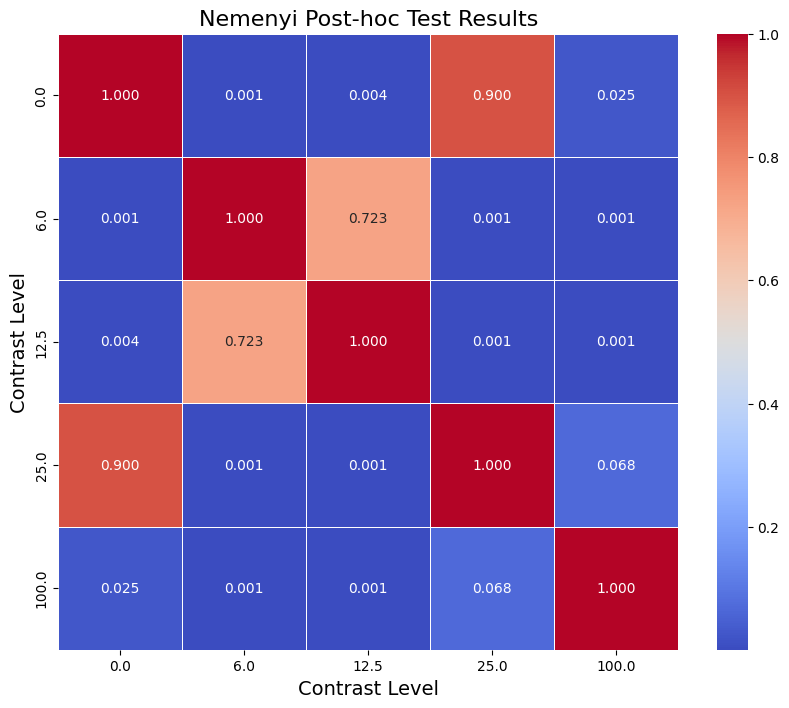

In [12]:
from scikit_posthocs import posthoc_nemenyi_friedman
# Pivot the data
pivoted_data = data.pivot(index='subject', columns='contrast', values='itc_mean')

# Perform the Nemenyi post-hoc test
nemenyi_results = posthoc_nemenyi_friedman(pivoted_data)

# Display the results
print(nemenyi_results)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_results, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)

# Add titles and labels
plt.title("Nemenyi Post-hoc Test Results", fontsize=16)
plt.xlabel('Contrast Level', fontsize=14)
plt.ylabel('Contrast Level', fontsize=14)

plt.show()

/tmp/ipykernel_267615/1456648663.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='contrast', y='itc_mean', data=data, palette="Set2")


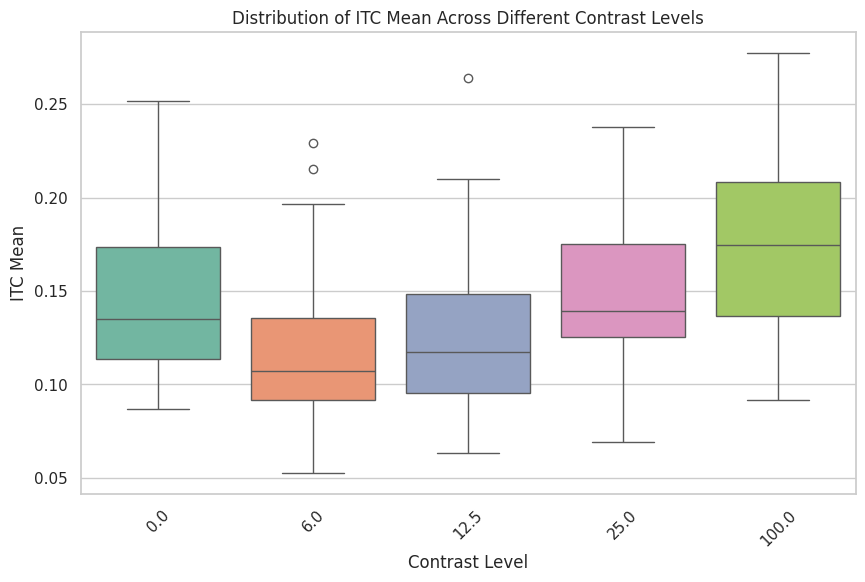

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
pivoted_data = data.pivot( columns='contrast', values='itc_mean')

# Set the style for the plots
sns.set(style="whitegrid")

# Create a boxplot to show the distribution of ITC mean across different contrast levels
plt.figure(figsize=(10, 6))
sns.boxplot(x='contrast', y='itc_mean', data=data, palette="Set2")

plt.title('Distribution of ITC Mean Across Different Contrast Levels')
plt.xlabel('Contrast Level')
plt.ylabel('ITC Mean')
plt.xticks(rotation=45)
plt.show()




# spearmanr
to test the correlation between the contrast and the ITC, I used the Spearman correlation

0.26797752760051075 0.000124837906331704


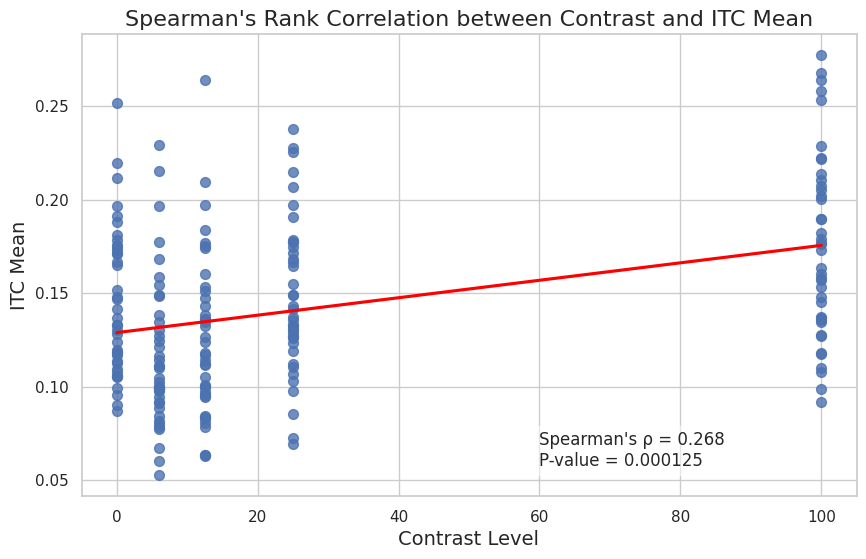

In [27]:
from scipy.stats import spearmanr

# Perform Spearman's rank correlation between contrast and ITC mean
# Flattening the data to compare contrast and ITC mean directly
contrast = data['contrast']
itc_mean = data['itc_mean']

spearman_corr, spearman_p_value = spearmanr(contrast, itc_mean)

# print(spearman_corr, spearman_p_value)
# Create a scatter plot with a regression line to illustrate Spearman's rank correlation

plt.figure(figsize=(10, 6))
sns.regplot(x=contrast, y=itc_mean, scatter_kws={'s':50}, ci=None, line_kws={'color':'red'}, marker='o')

# Add titles and labels
plt.title("Spearman's Rank Correlation between Contrast and ITC Mean", fontsize=16)
plt.xlabel('Contrast Level', fontsize=14)
plt.ylabel('ITC Mean', fontsize=14)
plt.grid(True)

# Display the correlation coefficient on the plot
plt.text(60, min(itc_mean) + 0.005, f"Spearman's ρ = {spearman_corr:.3f}\nP-value = {spearman_p_value:.3g}", 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()


# no stim itc in different time bins

In [1]:
import os
import numpy as np
import pandas as pd
import mne
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pickle

def compute_and_save_itc_stats(pids, n_jobs=20):
    
    data_dir = '/mnt/data/AdaptiveControl/IBLrawdata/pid_data/'
    output_path = 'itc_gocueeffect_stats_results.pkl'
    
    # Define time windows of interest
    time_windows = [(-1, -0.5), (-0.5, 0), (0, 0.5), (0.5, 1), (1, 1.5)]
    freq_range = np.arange(1, 14, 1)  # Frequencies from 1 to 13 Hz

    # Function to compute mean ITC over the specified time and frequency range for a given subject and condition
    def compute_mean_itc(epochs, freqs, time_window, freq_range):
        print(f"  Computing ITC for time window {time_window}...")
        n_cycles = freqs / 2  # Define the number of cycles for each frequency
        itc = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=True, average=True, n_jobs=n_jobs)[1]
        itc_avg = itc.data.mean(axis=0)  # Average over channels
        time_mask = (itc.times >= time_window[0]) & (itc.times <= time_window[1])
        freq_mask = (itc.freqs >= freq_range[0]) & (itc.freqs <= freq_range[-1])
        return itc_avg[freq_mask][:, time_mask].mean()

    # Create a DataFrame to store ITC values, subjects, and conditions
    data = []

    print(f"Starting ITC computation for {len(pids)} subjects...")
    for pid in pids:
        print(f"Processing subject {pid}...")
        # Load the epochs for each subject
        path = os.path.join(data_dir, pid, f'lfp_{pid}_epoched.fif')
        epochs = mne.read_epochs(path)
        epochs = epochs.crop(tmin=-1, tmax=1.5)
        meta = epochs.metadata

        # Identify clean trials based on skewness
        clean_index = meta.index[meta['skewness'] < 1.5].tolist()
        print(f"  Found {len(clean_index)} clean trials for subject {pid}...")

        # Filter trials with contrast < 0.1
        condition_trial_indices = np.where((meta['contrastLeft'] < 0.1) | (meta['contrastRight'] < 0.1))[0]

        # Intersect with clean trials
        clean_condition_trials = np.intersect1d(condition_trial_indices, clean_index)

        # Check if there are any valid trials
        if len(clean_condition_trials) == 0:
            print(f"  No valid trials for subject {pid} with contrast < 0.1.")
            continue

        subject_data = []

        for time_window in time_windows:
            itc_mean = compute_mean_itc(epochs[clean_condition_trials], freqs=freq_range, time_window=time_window, freq_range=freq_range)
            
            # Check if the computed ITC contains NaN values
            if not np.isnan(itc_mean):
                subject_data.append({'subject': pid, 'time_window': time_window, 'itc_mean': itc_mean})
            else:
                print(f"  NaN value encountered for subject {pid} in time window {time_window}. Skipping this time window.")

        # If the subject has valid ITC data for all time windows, add it to the main data list
        if len(subject_data) == len(time_windows):
            data.extend(subject_data)
            print(f"  Added ITC data for subject {pid}.")
        else:
            print(f"  Skipping subject {pid} due to missing data in one or more time windows.")

    # Convert the data list to a DataFrame for analysis
    df = pd.DataFrame(data)

    # Debugging: Print the first few rows of the DataFrame and its columns
    print("\nDataFrame columns:", df.columns)
    print("DataFrame preview:\n", df.head())

    # Perform a linear regression analysis to test if ITC is higher in the (0, 0.5) time window
    print("Performing linear regression analysis...")
    df['target_window'] = df['time_window'].apply(lambda x: 1 if x == (0, 0.5) else 0)

    try:
        model = smf.ols("itc_mean ~ target_window", data=df).fit()
        # Save the model and the data
        print(f"Saving the model and data to {output_path}...")
        with open(output_path, 'wb') as f:
            pickle.dump({'model': model, 'data': df}, f)
        print(f"Model and data saved to {output_path}. Processing complete.")
    except Exception as e:
        print(f"An error occurred during model fitting: {e}")
        return


In [2]:
import submitit

path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)
pids = df['pid'].values
# pids = pids[1:2]
executor = submitit.AutoExecutor(folder="logs")
# pass parameter to the executor
executor.update_parameters(mem_gb=40, timeout_min=600, slurm_partition="CPU", cpus_per_task=20)

# execute the job (note the .map_array command that different from the .submit command used above)
jobs = executor.submit(compute_and_save_itc_stats,pids)

<Figure size 1000x600 with 0 Axes>

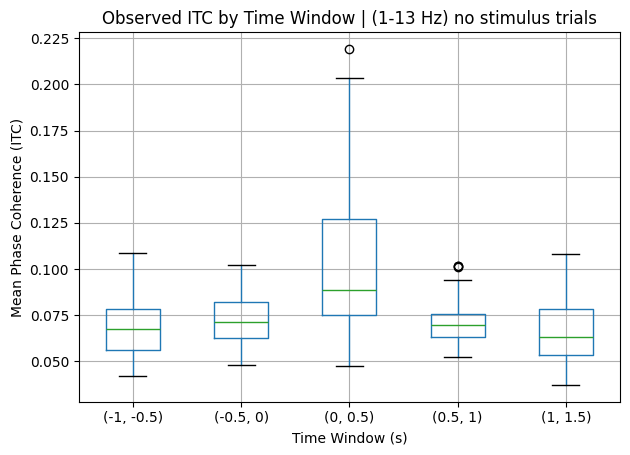

In [17]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# Load the model and data
result_path = 'itc_gocueeffect_stats_results.pkl'
with open(result_path, 'rb') as f:
    results = pickle.load(f)

df = results['data']

# Plot the observed ITC for each time window
plt.figure(figsize=(10, 6))
df.boxplot(column='itc_mean', by='time_window', grid=False)

# Customize the plot
plt.xlabel('Time Window (s)')
plt.ylabel('Mean Phase Coherence (ITC)')
plt.title('Observed ITC by Time Window | (1-13 Hz) no stimulus trials')
plt.suptitle('')  # Suppress the automatic subtitle generated by Pandas
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
